In [36]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn import under_sampling 
from imblearn import over_sampling
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [37]:
data = pd.read_csv("application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("credit_record.csv", encoding = 'utf-8')

In [38]:
plt.rcParams['figure.facecolor'] = 'white'

In [39]:
data.shape

(438557, 18)

## CLEANING


In [40]:
record.shape

(1048575, 3)

In [41]:
data.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [42]:
print(f'Duplicates in applications df: {data.iloc[:,1:].duplicated().sum()}, ({np.round(100*data.iloc[:,1:].duplicated().sum()/len(data),1)}%)')
print('')
print(f'Duplicates in record df: {record.duplicated().sum()}, ({np.round(100*record.duplicated().sum()/len(record),1)}%)')

Duplicates in applications df: 348472, (79.5%)

Duplicates in record df: 0, (0.0%)


In [43]:
data.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [44]:
data=data.drop_duplicates(subset=data.columns[1:], keep='first')

In [45]:
data.shape

(90085, 18)

In [46]:
#c1 fillna occupation_type
data['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)

In [47]:
# Drop constant feature
data.drop('FLAG_MOBIL', axis=1, inplace=True)

## eda data

In [48]:
gender_val = data.CODE_GENDER.value_counts(normalize = True)
gender_val

F    0.649487
M    0.350513
Name: CODE_GENDER, dtype: float64

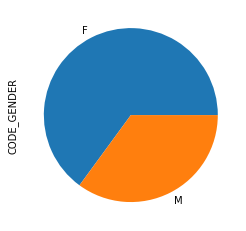

In [49]:
gender_val.plot.pie()
plt.show()

#Around 67.14% of the applicants are female

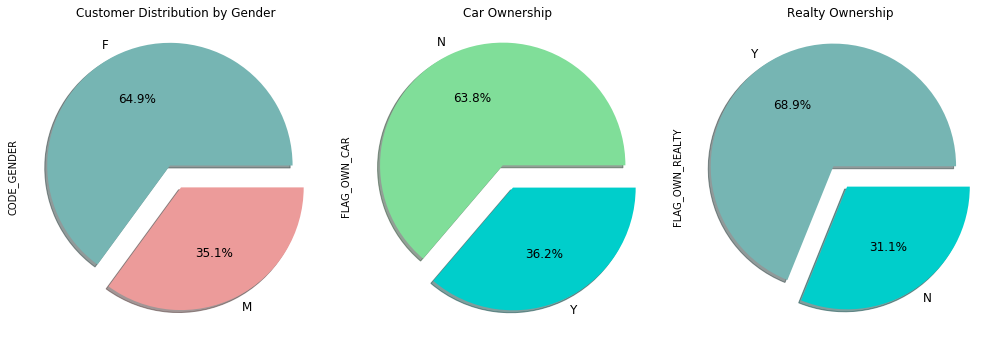

In [50]:
fig, axes = plt.subplots(1,3)

g1= data['CODE_GENDER'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True, colors=["#76B5B3","#EC9B9A"],textprops = {'fontsize':12}, ax=axes[0])
g1.set_title("Customer Distribution by Gender")

g2= data['FLAG_OWN_CAR'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#80DE99","#00CECB"],textprops = {'fontsize':12}, ax=axes[1])
g2.set_title("Car Ownership")

g3= data['FLAG_OWN_REALTY'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,colors=["#76B5B3","#00CECB"],textprops = {'fontsize':12}, ax=axes[2])
g3.set_title("Realty Ownership")

fig.set_size_inches(14,5)

plt.tight_layout()

plt.show()

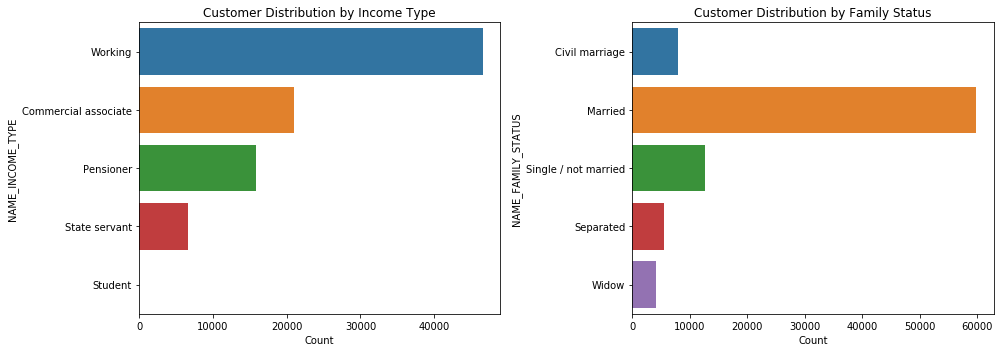

In [51]:
fig, axes = plt.subplots(1,2)

g1=sns.countplot(y=data.NAME_INCOME_TYPE,linewidth=1.2, ax=axes[0])
g1.set_title("Customer Distribution by Income Type")
g1.set_xlabel("Count")

g2=sns.countplot(y=data.NAME_FAMILY_STATUS,linewidth=1.2, ax=axes[1])
g2.set_title("Customer Distribution by Family Status")
g2.set_xlabel("Count")

fig.set_size_inches(14,5)

plt.tight_layout()


plt.show()

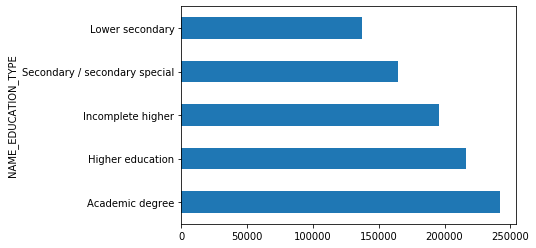

In [52]:
data.groupby(["NAME_EDUCATION_TYPE"]).AMT_INCOME_TOTAL.mean().sort_values(ascending=False).plot.barh()
plt.show()
#The average income increases with the education level.

In [53]:
#Mean & Median of amount income 
print(data.AMT_INCOME_TOTAL.mean())
print(data.AMT_INCOME_TOTAL.median())
#Mean of income = 178700 Median of income = 157500

178700.13874274297
157500.0


## target

In [54]:
record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


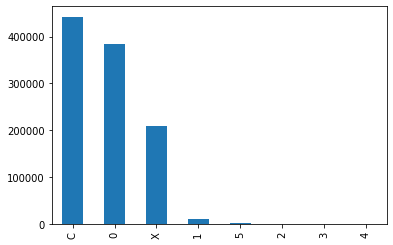

In [55]:
record.STATUS.value_counts().plot.bar()
plt.show()

In [56]:
#Find out for how long each customer has had a card
record['MONTHS_BALANCE'] = record.MONTHS_BALANCE.apply(lambda x : x*(-1))
cardholder_tenure = pd.DataFrame(record.groupby('ID').agg({'MONTHS_BALANCE' : max}))
cardholder_tenure.rename(columns = {'MONTHS_BALANCE':'CUST_FOR_MONTHS'},inplace = True)
cardholder_tenure.head()

,CUST_FOR_MONTHS
ID,
5001711,3
5001712,18
5001713,21
5001714,14
5001715,59


In [57]:
cust_data = pd.merge(data,cardholder_tenure,on = 'ID',how = 'inner')
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Other,2.0,15
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,29
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,4
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,Other,1.0,20
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,Accountants,2.0,5


In [58]:
cust_data.shape

(9709, 18)

In [59]:
record['STATUS'][record["STATUS"] == 'C'] = -1
record['STATUS'][record["STATUS"] == 'X'] = -1


In [60]:
record.STATUS.value_counts()

-1    651261
0     383120
1      11090
5       1693
2        868
3        320
4        223
Name: STATUS, dtype: int64

In [61]:
record['STATUS'] = record.STATUS.apply(lambda x : int(x))

In [62]:
record.sort_values(by = 'STATUS',ascending = False,inplace = True)
record.drop_duplicates(subset = ['ID'],inplace = True)
record.shape

(45985, 3)

In [63]:
record['target'] = record.STATUS.apply(lambda x : 0 if x>=2 else 1)
record.drop(['STATUS','MONTHS_BALANCE'],axis = 1,inplace = True)
record.head()

,ID,target
372050,5042064,0
307952,5029028,0
723708,5097065,0
942335,5135344,0
832456,5117313,0


In [64]:
record.target.value_counts()

1    45318
0      667
Name: target, dtype: int64

In [65]:
cust_data = pd.merge(cust_data,record, on = "ID", how = "inner")


In [66]:
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Other,2.0,15,1
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,29,1
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,4,1
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,Other,1.0,20,1
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,Accountants,2.0,5,1


In [67]:
cust_data.target.value_counts()

1    9503
0     206
Name: target, dtype: int64

In [68]:
#Convert binary categorical columns to have integer value
cust_data['CODE_GENDER'] = cust_data.CODE_GENDER.apply(lambda x : 0 if x == 'M' else 1)
cust_data['FLAG_OWN_CAR'] = cust_data.FLAG_OWN_CAR.apply(lambda x : 0 if x == 'N' else 1)
cust_data['FLAG_OWN_REALTY'] = cust_data.FLAG_OWN_REALTY.apply(lambda x : 0 if x == 'N' else 1)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Other,2.0,15,1
1,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,29,1
2,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,4,1
3,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,Other,1.0,20,1
4,5008815,0,1,1,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,Accountants,2.0,5,1


In [69]:
cust_data.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
count,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000
mean,5.076105e+06,0.651251,0.367700,0.671542,0.422804,1.812282e+05,-15991.811618,61732.846328,0.217427,0.287671,0.087548,2.182614,27.270059,0.978783
std,4.080270e+04,0.476599,0.482204,0.469677,0.767019,9.927731e+04,4246.224468,139656.322958,0.412517,0.452700,0.282650,0.932918,16.648057,0.144116
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.036955e+06,0.000000,0.000000,0.000000,0.000000,1.125000e+05,-19565.000000,-2995.000000,0.000000,0.000000,0.000000,2.000000,13.000000,1.000000
50%,5.069449e+06,1.000000,0.000000,1.000000,0.000000,1.575000e+05,-15611.000000,-1374.000000,0.000000,0.000000,0.000000,2.000000,26.000000,1.000000
75%,5.112986e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,-12440.000000,-339.000000,0.000000,1.000000,0.000000,3.000000,41.000000,1.000000
max,5.150479e+06,1.000000,1.000000,1.000000,19.000000,1.575000e+06,-7489.000000,365243.000000,1.000000,1.000000,1.000000,20.000000,60.000000,1.000000


In [70]:
#CNT_FAM_MEMBERS can not be float. Convert the column to int type
cust_data['CNT_FAM_MEMBERS'] = cust_data['CNT_FAM_MEMBERS'].astype('int')
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Other,2,15,1
1,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2,29,1
2,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1,4,1
3,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,Other,1,20,1
4,5008815,0,1,1,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,Accountants,2,5,1


In [71]:
def box_plot(df,col) :
    sns.boxplot(data = df, y = col)
    plt.show()

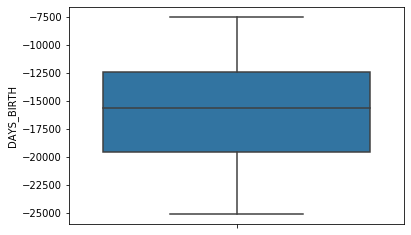

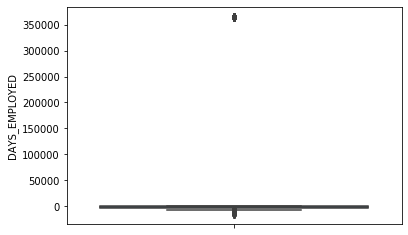

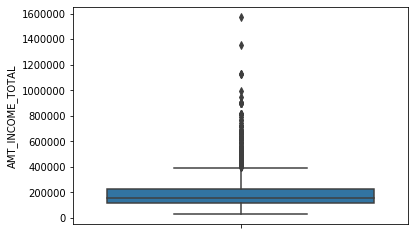

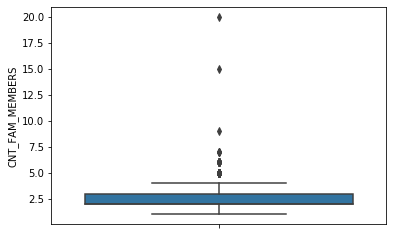

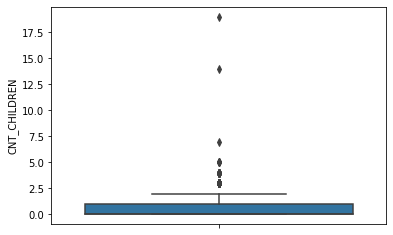

In [72]:
boxplt_col = ["DAYS_BIRTH","DAYS_EMPLOYED","AMT_INCOME_TOTAL","CNT_FAM_MEMBERS","CNT_CHILDREN"]
for col in boxplt_col :
    box_plot(cust_data,col)

In [73]:
cust_data[cust_data['DAYS_EMPLOYED'] > 0]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
3,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,Other,1,20,1
16,5008884,1,0,1,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186,365243,0,0,0,Other,1,40,1
24,5008974,1,0,1,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22319,365243,0,0,0,Other,2,49,1
34,5009033,1,0,0,0,255150.0,Pensioner,Incomplete higher,Civil marriage,Rented apartment,-18682,365243,0,0,0,Other,2,16,1
40,5009060,1,0,1,0,94500.0,Pensioner,Higher education,Married,House / apartment,-22331,365243,0,1,0,Other,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9681,5116549,1,0,1,0,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21312,365243,0,0,0,Other,2,27,0
9682,5116550,0,0,1,0,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21312,365243,0,0,0,Other,2,23,0
9686,5118280,1,0,0,0,112500.0,Pensioner,Secondary / secondary special,Single / not married,Municipal apartment,-21363,365243,0,0,0,Other,2,48,0
9687,5118283,0,0,0,0,112500.0,Pensioner,Secondary / secondary special,Married,Municipal apartment,-21363,365243,0,0,0,Other,2,39,0


In [74]:
cust_data[(cust_data['DAYS_EMPLOYED'] > 0) & (cust_data.NAME_INCOME_TYPE == 'Pensioner')].shape

(1696, 19)

In [75]:
def convert_to_positive(df,column) :
    df[column] = df[column].apply(lambda x : x*-1)
    return df

In [76]:
continuous_variable = ['DAYS_BIRTH','DAYS_EMPLOYED']
for c in continuous_variable :
    cust_data = convert_to_positive(cust_data,c)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Other,2,15,1
1,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,21474,1134,0,0,0,Security staff,2,29,1
2,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,19110,3051,0,1,1,Sales staff,1,4,1
3,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,22464,-365243,0,0,0,Other,1,20,1
4,5008815,0,1,1,0,270000.0,Working,Higher education,Married,House / apartment,16872,769,1,1,1,Accountants,2,5,1


In [77]:
cust_data['EMP_YEARS'] = cust_data.DAYS_EMPLOYED/365
cust_data['AGE'] = cust_data.DAYS_BIRTH/365
cust_data.drop(["DAYS_BIRTH","DAYS_EMPLOYED"],axis = 1,inplace = True)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Other,2,15,1,12.443836,32.890411
1,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2,29,1,3.106849,58.832877
2,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,4,1,8.358904,52.356164
3,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,0,0,0,Other,1,20,1,-1000.665753,61.545205
4,5008815,0,1,1,0,270000.0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2,5,1,2.106849,46.224658


In [78]:
#Replacing all the EMP_YEARS for all pensioners to be -1.
cust_data['EMP_YEARS'] = cust_data.EMP_YEARS.apply(lambda x : -1 if x<0 else x)

In [79]:
def bad_cust_proportion(col) :
    bad_prop_cnt = cust_data.groupby([col,'target']).agg({'ID': 'count'})
    bad_prop_percent = bad_prop_cnt.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    return bad_prop_percent

In [80]:
bad_cust_proportion('FLAG_OWN_CAR')
#Proportion of bad customers for people who own a car is less than those who don't own a car

ID
FLAG_OWN_CAR target           
0            0        2.182766
             1       97.817234
1            0        2.016807
             1       97.983193

In [81]:
bad_cust_proportion('NAME_HOUSING_TYPE')
#People living on rent don't have the highest proportion of bad customers.
#People having 'Office apartment' have the highest proportion of bad customers

ID
NAME_HOUSING_TYPE   target            
Co-op apartment     1       100.000000
House / apartment   0         2.061262
                    1        97.938738
Municipal apartment 0         4.334365
                    1        95.665635
Office apartment    0         1.315789
                    1        98.684211
Rented apartment    0         2.083333
                    1        97.916667
With parents        0         2.008929
                    1        97.991071

In [82]:
bad_cust_proportion('NAME_FAMILY_STATUS')

ID
NAME_FAMILY_STATUS   target           
Civil marriage       0        1.435407
                     1       98.564593
Married              0        1.807044
                     1       98.192956
Separated            0        2.264808
                     1       97.735192
Single / not married 0        3.752759
                     1       96.247241
Widow                0        2.926829
                     1       97.073171

In [83]:
cust_data['OCCUPATION_TYPE'] = cust_data.OCCUPATION_TYPE.apply(lambda x : 'UNEMPLOYED' if pd.isnull(x) else x)
cust_data.OCCUPATION_TYPE.value_counts()

Other                    2994
Laborers                 1724
Sales staff               959
Core staff                877
Managers                  782
Drivers                   623
High skill tech staff     357
Accountants               300
Medicine staff            291
Cooking staff             193
Security staff            182
Cleaning staff            146
Private service staff      86
Low-skill Laborers         53
Secretaries                46
Waiters/barmen staff       40
HR staff                   22
IT staff                   18
Realty agents              16
Name: OCCUPATION_TYPE, dtype: int64

## woe, iv

In [84]:
def calc_woe_iv(col) :
    df = pd.DataFrame(columns = ['values','total','good','bad','event_rate','non_event_rate','per_total_events','per_total_non_events','WOE','IV'])
    df['values'] = cust_data[col].unique()
    df.set_index('values',inplace = True)
    
    values = cust_data[col].unique()
    total_dict = dict(cust_data.groupby(col).size())
    col_target_dict = dict(cust_data.groupby([col,'target']).size())
    target_count = dict(cust_data.groupby(['target']).size())
    
    for value in values :
        df.loc[value]['total'] = total_dict[value]
        if (value,1) in col_target_dict:
            df.loc[value]['good'] = col_target_dict[(value,1)]
        else :
            df.loc[value]['good'] = 0
        
        if (value,0) in col_target_dict:
            df.loc[value]['bad'] = col_target_dict[(value,0)]
        else :
            df.loc[value]['bad'] = 0
            
        if df.loc[value]['bad'] == 0 :
            df = df.drop([value])
        
    df['event_rate'] = df['good']/df['total']
    df['non_event_rate'] = df['bad']/df['total']
    
    df['per_total_events'] = df['good']/target_count[1]
    df['per_total_non_events'] = df['bad']/target_count[0]
    
    df['WOE'] = np.log(df.per_total_events.astype('float64')/df.per_total_non_events.astype('float64'))
    df['IV'] = (df['per_total_events'] - df['per_total_non_events']) * df['WOE']
    
    return df    

In [85]:
iv_values = pd.DataFrame(columns = ['col_name','iv_value'])

In [86]:
iv_values['col_name'] = cust_data.columns
iv_values.set_index(['col_name'],inplace = True)
iv_values.drop(['ID','target'],inplace = True)
iv_values


,iv_value
col_name,
CODE_GENDER,NaN
FLAG_OWN_CAR,NaN
FLAG_OWN_REALTY,NaN
CNT_CHILDREN,NaN
AMT_INCOME_TOTAL,NaN
NAME_INCOME_TYPE,NaN
NAME_EDUCATION_TYPE,NaN
NAME_FAMILY_STATUS,NaN
NAME_HOUSING_TYPE,NaN


In [87]:
CODE_GENDER_df = calc_woe_iv('CODE_GENDER')
iv_values.loc['CODE_GENDER'] = CODE_GENDER_df.IV.sum()
print(iv_values.loc['CODE_GENDER'])
CODE_GENDER_df

iv_value    0.0341479
Name: CODE_GENDER, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
0,3386,3296,90,0.97342,0.02658,0.346838,0.436893,-0.230831,0.0207876
1,6323,6207,116,0.981654,0.0183457,0.653162,0.563107,0.148356,0.0133603


In [88]:
FLAG_OWN_CAR_df = calc_woe_iv('FLAG_OWN_CAR')
iv_values.loc['FLAG_OWN_CAR'] = FLAG_OWN_CAR_df.IV.sum()
print(iv_values.loc['FLAG_OWN_CAR'])
FLAG_OWN_CAR_df

iv_value    0.00150073
Name: FLAG_OWN_CAR, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,3570,3498,72,0.979832,0.0201681,0.368094,0.349515,0.051794,0.000962316
0,6139,6005,134,0.978172,0.0218277,0.631906,0.650485,-0.028979,0.000538416


In [89]:
FLAG_OWN_REALTY_df = calc_woe_iv('FLAG_OWN_REALTY')
iv_values.loc['FLAG_OWN_REALTY'] = FLAG_OWN_REALTY_df.IV.sum()
print(iv_values.loc['FLAG_OWN_REALTY'])
FLAG_OWN_REALTY_df

iv_value    0.0394361
Name: FLAG_OWN_REALTY, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,6520,6401,119,0.981748,0.0182515,0.673577,0.57767,0.153599,0.0147312
0,3189,3102,87,0.972719,0.0272813,0.326423,0.42233,-0.257592,0.0247049


In [90]:
FLAG_WORK_PHONE_df = calc_woe_iv('FLAG_WORK_PHONE')
iv_values.loc['FLAG_WORK_PHONE'] = FLAG_WORK_PHONE_df.IV.sum()
print(iv_values.loc['FLAG_WORK_PHONE'])
FLAG_WORK_PHONE_df

iv_value    0.00509095
Name: FLAG_WORK_PHONE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,2111,2072,39,0.981525,0.0184747,0.218036,0.18932,0.141221,0.00405531
0,7598,7431,167,0.978021,0.0219795,0.781964,0.81068,-0.036065,0.00103564


In [91]:
FLAG_PHONE_df = calc_woe_iv('FLAG_PHONE')
iv_values.loc['FLAG_PHONE'] = FLAG_PHONE_df.IV.sum()
print(iv_values.loc['FLAG_PHONE'])
FLAG_PHONE_df

iv_value    0.00164948
Name: FLAG_PHONE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
0,6916,6773,143,0.979323,0.0206767,0.712722,0.694175,0.026368,0.000489064
1,2793,2730,63,0.977444,0.0225564,0.287278,0.305825,-0.062564,0.00116042


In [92]:
FLAG_EMAIL_df = calc_woe_iv('FLAG_EMAIL')
iv_values.loc['FLAG_EMAIL'] = FLAG_EMAIL_df.IV.sum()
print(iv_values.loc['FLAG_EMAIL'])
FLAG_EMAIL_df

iv_value    0.00559887
Name: FLAG_EMAIL, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
0,8859,8667,192,0.978327,0.0216729,0.912028,0.932039,-0.021704,0.000434321
1,850,836,14,0.983529,0.0164706,0.0879722,0.0679612,0.258085,0.00516455


In [93]:
NAME_INCOME_TYPE_df = calc_woe_iv('NAME_INCOME_TYPE')
iv_values.loc['NAME_INCOME_TYPE'] = NAME_INCOME_TYPE_df.IV.sum()
print(iv_values.loc['NAME_INCOME_TYPE'])
NAME_INCOME_TYPE_df

iv_value    0.13214
Name: NAME_INCOME_TYPE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
Working,4960,4869,91,0.981653,0.0183468,0.512365,0.441748,0.148298,0.0104723
Commercial associate,2312,2274,38,0.983564,0.016436,0.239293,0.184466,0.260223,0.0142672
Pensioner,1712,1645,67,0.960864,0.0391355,0.173103,0.325243,-0.630684,0.0959519
State servant,722,712,10,0.98615,0.0138504,0.0749237,0.0485437,0.434006,0.0114491


In [94]:
NAME_EDUCATION_TYPE_df = calc_woe_iv('NAME_EDUCATION_TYPE')
iv_values.loc['NAME_EDUCATION_TYPE'] = NAME_EDUCATION_TYPE_df.IV.sum()
print(iv_values.loc['NAME_EDUCATION_TYPE'])
NAME_EDUCATION_TYPE_df

iv_value    0.0104004
Name: NAME_EDUCATION_TYPE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
Higher education,2457,2404,53,0.978429,0.021571,0.252973,0.257282,-0.016889,7.27726e-05
Secondary / secondary special,6761,6620,141,0.979145,0.0208549,0.696622,0.684466,0.017604,0.000213997
Incomplete higher,371,364,7,0.981132,0.0188679,0.0383037,0.0339806,0.119757,0.000517723
Lower secondary,114,109,5,0.95614,0.0438596,0.0114701,0.0242718,-0.749577,0.00959592


In [95]:
NAME_FAMILY_STATUS_df = calc_woe_iv('NAME_FAMILY_STATUS')
iv_values.loc['NAME_FAMILY_STATUS'] = NAME_FAMILY_STATUS_df.IV.sum()
print(iv_values.loc['NAME_FAMILY_STATUS'])
NAME_FAMILY_STATUS_df

iv_value    0.0982189
Name: NAME_FAMILY_STATUS, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
Civil marriage,836,824,12,0.985646,0.0143541,0.0867095,0.0582524,0.397777,0.0113196
Married,6530,6412,118,0.98193,0.0180704,0.674734,0.572816,0.163755,0.0166897
Single / not married,1359,1308,51,0.962472,0.0375276,0.137641,0.247573,-0.587058,0.0645365
Separated,574,561,13,0.977352,0.0226481,0.059034,0.0631068,-0.066715,0.000271718
Widow,410,398,12,0.970732,0.0292683,0.0418815,0.0582524,-0.329941,0.00540144


In [96]:
NAME_HOUSING_TYPE_df = calc_woe_iv('NAME_HOUSING_TYPE')
iv_values.loc['NAME_HOUSING_TYPE'] = NAME_HOUSING_TYPE_df.IV.sum()
print(iv_values.loc['NAME_HOUSING_TYPE'])
NAME_HOUSING_TYPE_df

iv_value    0.028521
Name: NAME_HOUSING_TYPE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
Rented apartment,144,141,3,0.979167,0.0208333,0.0148374,0.0145631,0.018661,5.11894e-06
House / apartment,8684,8505,179,0.979387,0.0206126,0.894981,0.868932,0.029537,0.000769396
Municipal apartment,323,309,14,0.956656,0.0433437,0.032516,0.0679612,-0.737203,0.0261302
With parents,448,439,9,0.979911,0.0200893,0.0461959,0.0436893,0.055788,0.00013984
Office apartment,76,75,1,0.986842,0.0131579,0.00789224,0.00485437,0.486001,0.00147641


In [97]:
OCCUPATION_TYPE_df = calc_woe_iv('OCCUPATION_TYPE')
iv_values.loc['OCCUPATION_TYPE'] = OCCUPATION_TYPE_df.IV.sum()
print(iv_values.loc['OCCUPATION_TYPE'])
OCCUPATION_TYPE_df

iv_value    0.105783
Name: OCCUPATION_TYPE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
Other,2994,2920,74,0.975284,0.0247161,0.307271,0.359223,-0.156213,0.00811556
Security staff,182,179,3,0.983516,0.0164835,0.0188362,0.0145631,0.257287,0.0010994
Sales staff,959,947,12,0.987487,0.012513,0.0996527,0.0582524,0.536906,0.0222281
Accountants,300,294,6,0.98,0.02,0.0309376,0.0291262,0.060334,0.000109287
Laborers,1724,1694,30,0.982599,0.0174014,0.178259,0.145631,0.202164,0.00659629
Managers,782,769,13,0.983376,0.016624,0.0809218,0.0631068,0.248655,0.00442979
Drivers,623,607,16,0.974318,0.0256822,0.0638746,0.0776699,-0.195547,0.00269763
Core staff,877,848,29,0.966933,0.0330673,0.089235,0.140777,-0.455902,0.023498
High skill tech staff,357,348,9,0.97479,0.0252101,0.03662,0.0436893,-0.176509,0.00124779


In [98]:
cust_data.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE
count,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000
mean,5.076105e+06,0.651251,0.367700,0.671542,0.422804,1.812282e+05,0.217427,0.287671,0.087548,2.182614,27.270059,0.978783,5.493810,43.813183
std,4.080270e+04,0.476599,0.482204,0.469677,0.767019,9.927731e+04,0.412517,0.452700,0.282650,0.932918,16.648057,0.144116,6.511702,11.633492
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.700000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,20.517808
25%,5.036955e+06,0.000000,0.000000,0.000000,0.000000,1.125000e+05,0.000000,0.000000,0.000000,2.000000,13.000000,1.000000,0.928767,34.082192
50%,5.069449e+06,1.000000,0.000000,1.000000,0.000000,1.575000e+05,0.000000,0.000000,0.000000,2.000000,26.000000,1.000000,3.764384,42.769863
75%,5.112986e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,0.000000,1.000000,0.000000,3.000000,41.000000,1.000000,8.205479,53.602740
max,5.150479e+06,1.000000,1.000000,1.000000,19.000000,1.575000e+06,1.000000,1.000000,1.000000,20.000000,60.000000,1.000000,43.049315,68.909589


In [99]:
#Since all the bins should have atleast 5% of the total observations, therefore dividing 'CNT_CHILDREN' into [0,1,1+] bins

In [100]:
cust_data['cnt_child_category'] = cust_data.CNT_CHILDREN.apply(lambda x : '1+' if x>= 2 else str(x))

In [101]:
CNT_CHILDREN_df = calc_woe_iv('cnt_child_category')
iv_values.loc['CNT_CHILDREN'] = CNT_CHILDREN_df.IV.sum()
print(iv_values.loc['CNT_CHILDREN'])
CNT_CHILDREN_df

iv_value    0.00684135
Name: CNT_CHILDREN, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
0,6819,6681,138,0.979762,0.0202376,0.703041,0.669903,0.048283,0.0016
1,1886,1844,42,0.977731,0.0222694,0.194044,0.203883,-0.049464,0.0004867
1+,1004,978,26,0.974104,0.0258964,0.102915,0.126214,-0.204074,0.00475465


In [102]:
bins = [0, 70000, 100000, 150000, 200000, 250000, 300000, 350000, 1600000]
labels = ['70000', '100000', '150000', '200000', '250000', '300000', '350000', '1600000']
cust_data['income_bin'] = pd.cut(cust_data['AMT_INCOME_TOTAL'], bins = bins, labels = labels)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE,cnt_child_category,income_bin
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,Other,2,15,1,12.443836,32.890411,0,1600000
1,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Security staff,2,29,1,3.106849,58.832877,0,150000
2,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1,4,1,8.358904,52.356164,0,300000
3,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,0,0,Other,1,20,1,-1.000000,61.545205,0,300000
4,5008815,0,1,1,0,270000.0,Working,Higher education,Married,House / apartment,...,1,1,Accountants,2,5,1,2.106849,46.224658,0,300000


In [103]:
cust_data.income_bin.value_counts()

150000     2753
200000     2081
250000     1720
100000     1048
300000      692
1600000     572
70000       492
350000      351
Name: income_bin, dtype: int64

In [104]:
AMT_INCOME_TOTAL_df = calc_woe_iv('income_bin')
iv_values.loc['AMT_INCOME_TOTAL'] = AMT_INCOME_TOTAL_df.IV.sum()
print(iv_values.loc['AMT_INCOME_TOTAL'])
AMT_INCOME_TOTAL_df.sort_values(by = 'WOE',inplace = True)
AMT_INCOME_TOTAL_df

iv_value    0.0444413
Name: AMT_INCOME_TOTAL, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
300000,692,669,23,0.966763,0.033237,0.0703988,0.11165,-0.461197,0.0190251
100000,1048,1019,29,0.972328,0.0276718,0.107229,0.140777,-0.272205,0.00913179
200000,2081,2037,44,0.978856,0.0211437,0.214353,0.213592,0.003557,2.70744e-06
150000,2753,2696,57,0.979295,0.0207047,0.2837,0.276699,0.024987,0.000174927
70000,492,483,9,0.981707,0.0182927,0.0508261,0.0436893,0.151305,0.00107983
350000,351,345,6,0.982906,0.017094,0.0363043,0.0291262,0.220298,0.00158133
250000,1720,1691,29,0.98314,0.0168605,0.177944,0.140777,0.234293,0.00870799
1600000,572,563,9,0.984266,0.0157343,0.0592444,0.0436893,0.304568,0.0047376


In [105]:
cust_data.CNT_FAM_MEMBERS.value_counts()


2     5183
1     1947
3     1635
4      802
5      117
6       18
7        4
15       1
20       1
9        1
Name: CNT_FAM_MEMBERS, dtype: int64

In [106]:
cust_data['cnt_family_bin'] = cust_data.CNT_FAM_MEMBERS.apply(lambda x : '3+' if x>= 4 else str(x))

In [107]:
CNT_FAM_MEMBERS_df = calc_woe_iv('cnt_family_bin')
iv_values.loc['CNT_FAM_MEMBERS'] = CNT_FAM_MEMBERS_df.IV.sum()
print(iv_values.loc['CNT_FAM_MEMBERS'])
CNT_FAM_MEMBERS_df.sort_values(by = 'WOE',inplace = True)
CNT_FAM_MEMBERS_df

iv_value    0.00571625
Name: CNT_FAM_MEMBERS, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,1947,1900,47,0.97586,0.0241397,0.199937,0.228155,-0.132025,0.00372555
3+,944,923,21,0.977754,0.0222458,0.0971272,0.101942,-0.048380,0.000232926
3,1635,1601,34,0.979205,0.0207951,0.168473,0.165049,0.020537,7.03288e-05
2,5183,5079,104,0.979934,0.0200656,0.534463,0.504854,0.056992,0.00168745


In [108]:
bins = [-1, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]
labels = ['0.5','1','1.5','2','2.5','3','3.5','4','4.5','5']
cust_data['months_bin'] = pd.cut(cust_data['CUST_FOR_MONTHS'], bins = bins,labels = labels)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE,cnt_child_category,income_bin,cnt_family_bin,months_bin
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,Other,2,15,1,12.443836,32.890411,0,1600000,2,1.5
1,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,Security staff,2,29,1,3.106849,58.832877,0,150000,2,2.5
2,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,Sales staff,1,4,1,8.358904,52.356164,0,300000,1,0.5
3,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,Other,1,20,1,-1.000000,61.545205,0,300000,1,2
4,5008815,0,1,1,0,270000.0,Working,Higher education,Married,House / apartment,...,Accountants,2,5,1,2.106849,46.224658,0,300000,2,0.5


In [109]:
CUST_FOR_MONTHS_df = calc_woe_iv('months_bin')
iv_values.loc['CUST_FOR_MONTHS'] = CUST_FOR_MONTHS_df.IV.sum()
print(iv_values.loc['CUST_FOR_MONTHS'])
CUST_FOR_MONTHS_df.sort_values(by = 'WOE',inplace = True)
CUST_FOR_MONTHS_df

iv_value    0.303485
Name: CUST_FOR_MONTHS, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
5,615,590,25,0.95935,0.0406504,0.0620857,0.121359,-0.670240,0.0397275
4.5,719,693,26,0.963839,0.0361613,0.0729243,0.126214,-0.548553,0.029232
4,830,800,30,0.963855,0.0361446,0.0841839,0.145631,-0.548072,0.0336775
3.5,991,962,29,0.970737,0.0292634,0.101231,0.140777,-0.329768,0.0130408
1.5,1229,1203,26,0.978845,0.0211554,0.126592,0.126214,0.002991,1.13045e-06
3,938,920,18,0.98081,0.0191898,0.0968115,0.0873786,0.102515,0.000967015
2.5,980,962,18,0.981633,0.0183673,0.101231,0.0873786,0.147156,0.00203849
1,1180,1164,16,0.986441,0.0135593,0.122488,0.0776699,0.455542,0.0204164
2,1080,1068,12,0.988889,0.0111111,0.112386,0.0582524,0.657150,0.0355736


In [110]:
bins = [-2, -1,  5, 10, 15,  20, 50]
labels = ['retired','5','10','15','20','20+']
cust_data['emp_years_bin'] = pd.cut(cust_data['EMP_YEARS'], bins = bins, labels = labels)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE,cnt_child_category,income_bin,cnt_family_bin,months_bin,emp_years_bin
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,2,15,1,12.443836,32.890411,0,1600000,2,1.5,15
1,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,2,29,1,3.106849,58.832877,0,150000,2,2.5,5
2,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,4,1,8.358904,52.356164,0,300000,1,0.5,10
3,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,1,20,1,-1.000000,61.545205,0,300000,1,2,retired
4,5008815,0,1,1,0,270000.0,Working,Higher education,Married,House / apartment,...,2,5,1,2.106849,46.224658,0,300000,2,0.5,5


In [111]:
cust_data.emp_years_bin.value_counts()

5          4054
10         2196
retired    1696
15          941
20+         411
20          411
Name: emp_years_bin, dtype: int64

In [112]:
EMP_YEARS_df = calc_woe_iv('emp_years_bin')
iv_values.loc['EMP_YEARS'] = EMP_YEARS_df.IV.sum()
print(iv_values.loc['EMP_YEARS'])
EMP_YEARS_df.sort_values(by = 'WOE',inplace = True)
EMP_YEARS_df

iv_value    0.0561024
Name: EMP_YEARS, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
retired,1696,1645,51,0.969929,0.0300708,0.173103,0.247573,-0.357817,0.0266465
5,4054,3963,91,0.977553,0.022447,0.417026,0.441748,-0.057590,0.00142369
20,411,404,7,0.982968,0.0170316,0.0425129,0.0339806,0.224018,0.00191139
10,2196,2160,36,0.983607,0.0163934,0.227297,0.174757,0.262858,0.0138104
15,941,926,15,0.98406,0.0159405,0.0974429,0.0728155,0.291337,0.00717488
20+,411,405,6,0.985401,0.0145985,0.0426181,0.0291262,0.380641,0.00513557


In [113]:
bins = [19, 27, 30, 35, 40, 45, 50, 55, 62, 70]
labels = ['27','30','35','40','45','50','55','62','70']
cust_data['age_bin'] = pd.cut(cust_data['AGE'], bins = bins,labels = labels)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,CUST_FOR_MONTHS,target,EMP_YEARS,AGE,cnt_child_category,income_bin,cnt_family_bin,months_bin,emp_years_bin,age_bin
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,15,1,12.443836,32.890411,0,1600000,2,1.5,15,35
1,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,29,1,3.106849,58.832877,0,150000,2,2.5,5,62
2,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,4,1,8.358904,52.356164,0,300000,1,0.5,10,55
3,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,20,1,-1.000000,61.545205,0,300000,1,2,retired,62
4,5008815,0,1,1,0,270000.0,Working,Higher education,Married,House / apartment,...,5,1,2.106849,46.224658,0,300000,2,0.5,5,50


In [114]:
AGE_df = calc_woe_iv('age_bin')
iv_values.loc['AGE'] = AGE_df.IV.sum()
print(iv_values.loc['AGE'])
AGE_df.sort_values(by = 'WOE',inplace = True)
AGE_df

iv_value    0.0413496
Name: AGE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
62,1406,1367,39,0.972262,0.0277383,0.143849,0.18932,-0.274674,0.0124897
35,1326,1294,32,0.975867,0.0241327,0.136168,0.15534,-0.131729,0.00252555
55,1119,1092,27,0.975871,0.0241287,0.114911,0.131068,-0.131557,0.00212556
70,675,659,16,0.976296,0.0237037,0.0693465,0.0776699,-0.113352,0.00094347
45,1332,1304,28,0.978979,0.021021,0.13722,0.135922,0.009501,1.2327e-05
30,794,780,14,0.982368,0.0176322,0.0820793,0.0679612,0.188750,0.00266481
40,1396,1372,24,0.982808,0.017192,0.144375,0.116505,0.214484,0.00597781
50,1110,1092,18,0.983784,0.0162162,0.114911,0.0873786,0.273908,0.00754135
27,551,543,8,0.985481,0.0145191,0.0571399,0.038835,0.386181,0.00706901


In [115]:
iv_values.sort_values(by = 'iv_value',ascending=False,inplace = True)
iv_values

,iv_value
col_name,
CUST_FOR_MONTHS,0.303485
NAME_INCOME_TYPE,0.13214
OCCUPATION_TYPE,0.105783
NAME_FAMILY_STATUS,0.0982189
EMP_YEARS,0.0561024
AMT_INCOME_TOTAL,0.0444413
AGE,0.0413496
FLAG_OWN_REALTY,0.0394361
CODE_GENDER,0.0341479


In [116]:
cust_data_train = cust_data[[ 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                             'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
                             'OCCUPATION_TYPE', 'CUST_FOR_MONTHS', 'cnt_child_category', 'income_bin', 'cnt_family_bin',
                             'months_bin', 'emp_years_bin', 'age_bin', 'target']]

In [117]:
def creatingDummyVariables(df, columns) :
    # Creating a dummy variable for some of the categorical variables and dropping the first one.
    dummy1 = pd.get_dummies(df[columns], drop_first=True)
    
    # Adding the results to the master dataframe
    df1 = pd.concat([df, dummy1], axis=1)
    
    #Dropping the initial column
    df1.drop(columns, axis = 1, inplace = True)
    
    return df1

In [118]:
cust_data_train = creatingDummyVariables(cust_data_train, ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                      'OCCUPATION_TYPE', 'cnt_child_category','income_bin', 'cnt_family_bin', 'months_bin',
                      'emp_years_bin', 'age_bin'])

In [119]:
cust_data_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CUST_FOR_MONTHS,target,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,...,emp_years_bin_20,emp_years_bin_20+,age_bin_30,age_bin_35,age_bin_40,age_bin_45,age_bin_50,age_bin_55,age_bin_62,age_bin_70
0,0,1,1,1,0,0,15,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,1,0,0,0,29,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,1,0,1,1,4,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,1,0,0,0,20,1,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,1,1,1,1,5,1,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Removing all columns with IV_value < 0.02

In [124]:
cust_data_train = cust_data[['CODE_GENDER','FLAG_OWN_REALTY','NAME_INCOME_TYPE',
                             'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                             'OCCUPATION_TYPE','CUST_FOR_MONTHS', 'income_bin',
                             'months_bin', 'emp_years_bin', 'age_bin',
                             'target']]

In [125]:
cust_data_train

,CODE_GENDER,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CUST_FOR_MONTHS,income_bin,months_bin,emp_years_bin,age_bin,target
0,0,1,Working,Civil marriage,Rented apartment,Other,15,1600000,1.5,15,35,1
1,0,1,Working,Married,House / apartment,Security staff,29,150000,2.5,5,62,1
2,1,1,Commercial associate,Single / not married,House / apartment,Sales staff,4,300000,0.5,10,55,1
3,1,1,Pensioner,Separated,House / apartment,Other,20,300000,2,retired,62,1
4,0,1,Working,Married,House / apartment,Accountants,5,300000,0.5,5,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9704,1,0,Pensioner,Civil marriage,Municipal apartment,Laborers,20,200000,2,5,62,0
9705,1,1,Commercial associate,Married,House / apartment,Other,19,150000,2,10,45,0
9706,0,1,Working,Married,House / apartment,Other,21,100000,2,5,55,0
9707,1,1,Pensioner,Married,House / apartment,Medicine staff,32,200000,3,5,35,0


In [126]:
cust_data_train = creatingDummyVariables(cust_data_train, ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                            'OCCUPATION_TYPE','income_bin', 'months_bin', 'emp_years_bin', 'age_bin'])

In [127]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy Score is 0.67211
      0     1
0  1765  1085
1   784  2066
[[0.61929825 0.38070175]
 [0.27508772 0.72491228]]


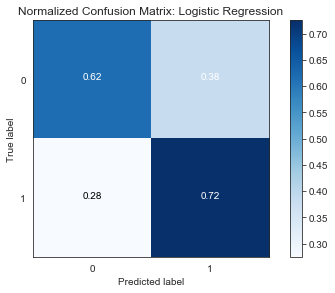

In [140]:
# Putting feature variable to X
X = cust_data_train.drop(['target'], axis=1)
y = cust_data_train['target']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,random_state = 42)

# scaling
from sklearn.preprocessing import MinMaxScaler
MMS =MinMaxScaler()
X_train= pd.DataFrame(MMS.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(MMS.fit_transform(X_test), columns=X_test.columns)

#oversampling
from imblearn.over_sampling import SMOTE
oversample= SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

#model
logmodel = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, logpred)))
print(pd.DataFrame(confusion_matrix(y_test,logpred)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,logpred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')


Accuracy Score is 0.82211
      0     1
0  1908   942
1    72  2778
[[0.66947368 0.33052632]
 [0.02526316 0.97473684]]


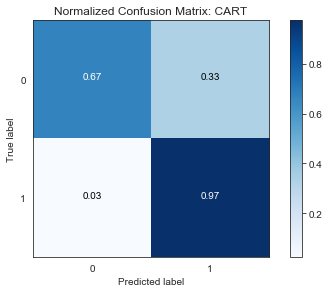

In [141]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini') #criterion = entopy, gini
dtree.fit(X_train, y_train)
dtreepred = dtree.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, dtreepred)))
print(pd.DataFrame(confusion_matrix(y_test,dtreepred)))

plot_confusion_matrix(confusion_matrix(y_test,dtreepred),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: CART')



  

In [142]:
def plot_AUC(logmodel, dtree, X_test, y_test):
    from sklearn import metrics
    fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    #Logistic
    probs = logmodel.predict_proba(X_test)
    preds = probs[:,1]
    fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, preds)
    roc_auclog = metrics.auc(fprlog, tprlog)

    ax.plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_auclog)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_title('Receiver Operating Characteristic Logistic ',fontsize=10)
    ax.set_ylabel('True Positive Rate',fontsize=20)
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.legend(loc = 'lower right', prop={'size': 16})
    #dtree
    probs = dtree.predict_proba(X_test)
    preds = probs[:,1]
    fprdtree, tprdtree, thresholddtree = metrics.roc_curve(y_test, preds)
    roc_aucdtree = metrics.auc(fprdtree, tprdtree)

    ax1.plot(fprdtree, tprdtree, 'b', label = 'AUC = %0.2f' % roc_aucdtree)
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_title('Receiver Operating Characteristic Decision Tree ',fontsize=10)
    ax1.set_ylabel('True Positive Rate',fontsize=20)
    ax1.set_xlabel('False Positive Rate',fontsize=15)
    ax1.legend(loc = 'lower right', prop={'size': 16})
    
    #randomforest
    

    plt.subplots_adjust(wspace=1)

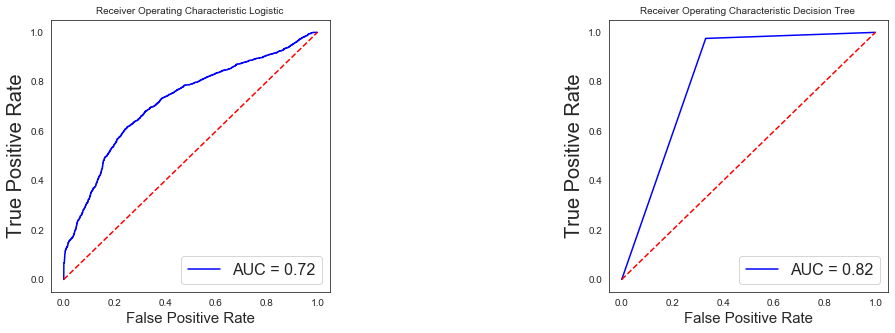

In [143]:
 plot_AUC(logmodel, dtree, X_test, y_test)

Accuracy Score is 0.8714
      0     1
0  2144   706
1    27  2823
[[0.7522807  0.2477193 ]
 [0.00947368 0.99052632]]


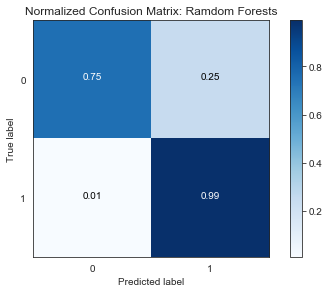

In [144]:
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')

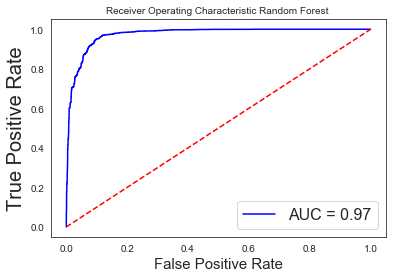

In [145]:
probs = model.predict_proba(X_test)
preds = probs[:,1]
fprrandom, tprrandom, thresholdrandom = metrics.roc_curve(y_test, preds)
roc_aucrandom = metrics.auc(fprrandom, tprrandom)

plt.plot(fprrandom, tprrandom, 'b', label = 'AUC = %0.2f' % roc_aucrandom)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Receiver Operating Characteristic Random Forest ',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 16})